In [1]:
import os 
import sys
sys.path.append("/home/martin/Work/Qutip/modules")
import math
import numpy as np
import Interferometry as In
import Utility as Ut
import parameters as pm
from qutip import Qobj, basis, sigmax, Options

# Setting up an impulse approximation interferometer

We consider an interferometric scheme, where we make use of the molecular ion MgH$^+$ as an example.
For this we need to specify two pulse strengths and a time delay. We also need a basis consisting of the rotational states. In our representation, we take $j = 0,2,4,..$, all with $m=0$. 

Additionally, we need to chose an initial state, typically the ground state corresponding to $j=0$. We also need to specify on which final state we measure the population on. This is usually the ground state.

In [2]:
dim     = 10 # The dimension of the basis, i.e. how many states we include in the representation
istate  = Qobj(basis(dim,0)) # The initial state set to the ground state
mstate  = 0 # The final state on which to measure the population (also the ground state)
Name    = 'Impulse interferometer'

Ps      = [1.89, 1.89] # The pulse strengths (atomic units)
B       = 2.88*10**(-5.) # The rotational constant of MgH^+ (atomic units)
Trot    = B**(-1.)
ts      = np.linspace(0.,4.*Trot,200) # An array of time delays (atomic units)

Pulses  = Ut.Pulses(Ps, ts) # The instance of the pulses class with the pulse strength and time delays 
IntP    = In.ImpactInterferometry(Ps, ts, B, istate, mstate, dim, Name) # INstance of the interferometry class

print("Print info for:", Name)
print()
print("Pulse strenghts:", Ps[0], Ps[1])
print("Min time delay:", ts[0]/Trot)
print("Max time delay:", ts[-1]/Trot)
print("Number of time delays:", len(ts))
print("Delta time delay:", (ts[1] - ts[0])/Trot)

Print info for: Impulse interferometer

Pulse strenghts: 1.89 1.89
Min time delay: 0.0
Max time delay: 4.0
Number of time delays: 200
Delta time delay: 0.020100502512562814


Now that we have set the parameters for the impulse interferometry scheme, we can run the interferometry

In [3]:
IntP.run_interferometry()

and now we plot the result

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
import numpy as np


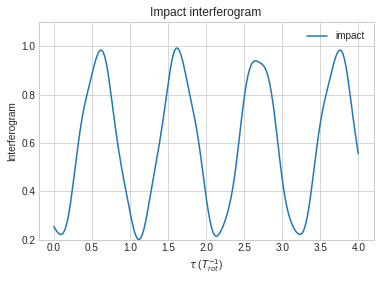

In [62]:
fig = plt.figure()
#ax = plt.axes()
plt.xlabel('$\\tau$ ($T_{rot}^{-1}$)')
plt.ylabel('Interferogram')
plt.title('Impact interferogram')
plt.ylim(bottom=0.2, top=1.1)
plt.plot(IntP.tau/Trot, IntP.inter, label='impact')
plt.legend(loc='upper right')
plt.show()

# Setting up the full pulse interferometer

We will run a few interferometer runs in the effective rotor approximation, with varying $FWHM$ and check if the results agree with the impact approximation for low values of $FWHM$ compared to the rotational time $\frac{1}{B}$. 

We start by considering $FWHM = 100$ fs.

In [106]:
FWHM = 100. # (fs)
sigma = Ut.sigmaFromFWHM(FWHM) # (atomic units)
time   = np.linspace(-7.*sigma, 4.5*Trot, 1000) # Time grid for numerical integration of the Schrödinger equation
Da = 9.12 # The polarizability anisotropy of MgH^+ (atomic units) (double check check value!)

tau = ts # use the same time delays as in the impact approximation
Twind = time[-1] - time[0] # The time window covered by the time grid
P = Ps[0] # Set the pulse strength equal to the that of the impact approximation
I0 = Ut.getI0(P, sigma, Da) # Obtain the max. pulse intensity from P and sigma

# Set the paramters for the me-solver
Pparam = {'I01': I0, 'I02': I0, 'sigma': sigma, 't0': 0., 'tau': tau}
Mparam = {'B': B, 'Da': Da}
Name   = 'ERA interferometer, 100 fs'
# Set options for performance and to store the final state so we can calculate the final population
options=Options(nsteps=3000, store_final_state=True)

# Write information to check consistency
print("Trot/sigma:", Trot/Pparam['sigma'])
print('sigma:', sigma, '(au)')
print('Trot:',Trot,'(au)')


print("Tgrid window:", Twind, "Twind/Trot:", Twind/Trot, "Twind/sigma:", Twind/sigma, "Twind/tau_max:", Twind/tau[-1])
print("Time delay:", tau[-1]/Trot)
print("Time resolution:", (time[1] - time[0])/sigma)

print('P =',P, '(au)')
print('I0 =',I0, '(au)')
print('Checking pulse strength analytical: P =', Ut.getP(Da, I0 ,sigma), '(au)')
print('Checking pulse strength numerical: P =', Ut.getP_int(Da, I0 , 0., sigma), '(au)')
print("Ratio analytical/numerical:",  Ut.getP(Da, I0 ,sigma)/Ut.getP_int(Da, I0 , 0., sigma))

Trot/sigma: 19.777907448044353
sigma: 1755.606467136925 (au)
Trot: 34722.22222222222 (au)
Tgrid window: 168539.24526995848 Twind/Trot: 4.853930263774805 Twind/sigma: 96.0005835161996 Twind/tau_max: 1.2134825659437012
Time delay: 4.0
Time resolution: 0.09609668019639613
P = 1.89 (au)
I0 = 0.0010270809207522133 (au)
Checking pulse strength analytical: P = 1.8899999999999997 (au)
Checking pulse strength numerical: P = 1.8899999999999715 (au)
Ratio analytical/numerical: 1.0000000000000149


In [102]:
IntPu    = In.PulsesInterferometry(Pparam, time, Mparam, istate, mstate, dim, Name)

In [103]:
IntPu.run_interferometry(options)

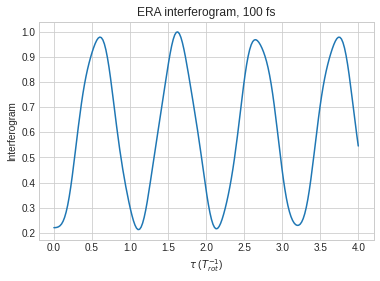

In [104]:
fig = plt.figure()
plt.xlabel('$\\tau$ ($T_{rot}^{-1}$)')
plt.ylabel('Interferogram')
plt.title('ERA interferogram, 100 fs')
plt.plot(IntPu.tau/Trot, IntPu.inter)
plt.show()

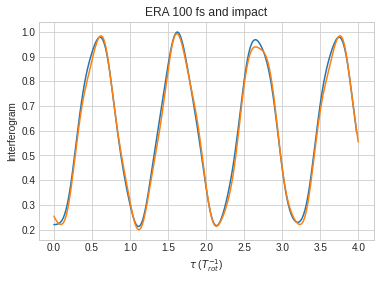

In [34]:
fig = plt.figure()
plt.xlabel('$\\tau$ ($T_{rot}^{-1}$)')
plt.ylabel('Interferogram')
plt.title('ERA interferogram, 100 fs with impact')
plt.ylim(bottom=0.2, top=1.2)
plt.plot(IntP.tau/Trot, IntP.inter, label='impact')
plt.plot(IntPu.tau/Trot, IntPu.inter, '--', label='ERA')
plt.legend(loc='upper right')
plt.show()

As we can see, the agreement between the two methods is pretty good. Let's check a lower value for $\sigma$ to check whether we can obtain even better agreement.

Next we consider $FWHM = 50$ fs.

In [69]:
FWHM = 50. # (fs)
sigma = Ut.sigmaFromFWHM(FWHM)
time   = np.linspace(-7.*sigma, 4.5*Trot, 1000)
I0 = Ut.getI0(P, sigma, Da)
Pparam.update(I01 = I0, I02 = I0, sigma = sigma) 
Name   = 'ERA interferometer, 50 fs'
print("Trot/sigma:", Trot/Pparam['sigma'])
print('sigma:', sigma, '(au)')
print('Trot:',Trot,'(au)')


print("Tgrid window:", Twind, "Twind/Trot:", Twind/Trot, "Twind/sigma:", Twind/sigma, "Twind/tau_max:", Twind/tau[-1])
print("Time delay:", tau[-1]/Trot)
print("Time resolution:", (time[1] - time[0])/sigma)

print('P =',P, '(au)')
print('I0 =',I0, '(au)')
print('Checking pulse strength analytical: P =', Ut.getP(Da, I0 ,sigma), '(au)')
print('Checking pulse strength numerical: P =', Ut.getP_int(Da, I0 , 0., sigma), '(au)')

Trot/sigma: 39.555814896088705
sigma: 877.8032335684625 (au)
Trot: 34722.22222222222 (au)
Tgrid window: 168539.24526995848 Twind/Trot: 4.853930263774805 Twind/sigma: 192.0011670323992 Twind/tau_max: 1.2195804682851268
Time delay: 3.98
Time resolution: 0.18518635338578485
P = 1.89 (au)
I0 = 0.0020541618415044266 (au)
Checking pulse strength analytical: P = 1.8899999999999997 (au)
Checking pulse strength numerical: P = 1.8899999999999713 (au)


In [70]:
IntPu2 = In.PulsesInterferometry(Pparam, time, Mparam, istate, mstate, dim, Name)
IntPu2.run_interferometry(options)

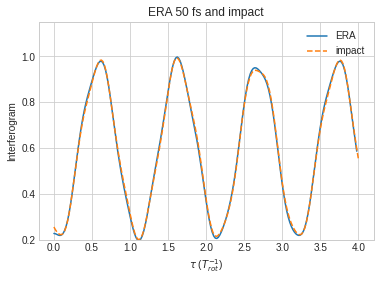

In [80]:
plt.xlabel('$\\tau$ ($T_{rot}^{-1}$)')
plt.ylabel('Interferogram')
plt.title('ERA 50 fs and impact')
plt.ylim(bottom=0.2, top=1.15)
plt.plot(IntPu2.tau/Trot, IntPu2.inter, label='ERA')
plt.plot(IntP.tau/Trot, IntP.inter, '--', label='impact')
plt.legend(loc='upper right')
plt.show()

As we can see, the agreement with the impact and ERA approximations are very satisfactory for $\sigma = 50$ fs.

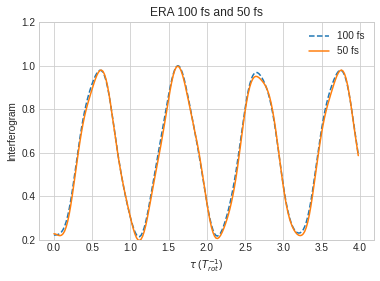

In [74]:
plt.xlabel('$\\tau$ ($T_{rot}^{-1}$)')
plt.ylim(bottom=0.2, top=1.2)
plt.ylabel('Interferogram')
plt.title('ERA 100 fs and 50 fs')
plt.plot(IntPu.tau/Trot, IntPu.inter, '--',label='100 fs')
plt.plot(IntPu2.tau/Trot, IntPu2.inter, label='50 fs')
plt.legend(loc='upper right')
plt.show()

The overall nice agreement between the interferograms for ERA at $\sigma= 50, 100$ fs indicates that the impact approximation works pretty well also at $\sigma = 100$ fs.

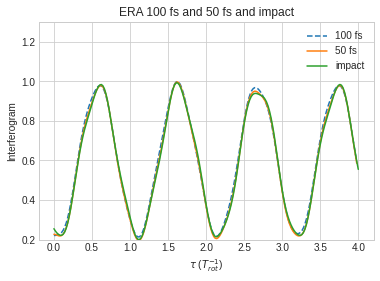

In [75]:
plt.xlabel('$\\tau$ ($T_{rot}^{-1}$)')
plt.ylim(bottom=0.2, top=1.3)
plt.ylabel('Interferogram')
plt.title('ERA 100 fs and 50 fs and impact')
plt.plot(IntPu.tau/Trot, IntPu.inter, '--',label='100 fs')
plt.plot(IntPu2.tau/Trot, IntPu2.inter, label='50 fs')
plt.plot(IntP.tau/Trot, IntP.inter, label='impact')
plt.legend(loc='upper right')
plt.show()

We have seen that the impact approximation works very well for $\sigma = 50$ fs, and pretty well for $\sigma = 100$ fs. Let' s see how it works for larger $\sigma$.

$FWHM = 200$ fs.

In [81]:
FWHM = 200. # (fs)
sigma = Ut.sigmaFromFWHM(FWHM)
time   = np.linspace(-7.*sigma, 4.5*Trot, 1000)
I0 = Ut.getI0(P, sigma, Da)
Pparam.update(I01 = I0, I02 = I0, sigma = sigma) 
Name   = 'ERA interferometer, 200 fs'
print("Trot/sigma:", Trot/Pparam['sigma'])
print('sigma:', sigma, '(au)')
print('Trot:',Trot,'(au)')


print("Tgrid window:", Twind, "Twind/Trot:", Twind/Trot, "Twind/sigma:", Twind/sigma, "Twind/tau_max:", Twind/tau[-1])
print("Time delay:", tau[-1]/Trot)
print("Time resolution:", (time[1] - time[0])/sigma)

print('P =',P, '(au)')
print('I0 =',I0, '(au)')
print('Checking pulse strength analytical: P =', Ut.getP(Da, I0 ,sigma), '(au)')
print('Checking pulse strength numerical: P =', Ut.getP_int(Da, I0 , 0., sigma), '(au)')

Trot/sigma: 9.888953724022176
sigma: 3511.21293427385 (au)
Trot: 34722.22222222222 (au)
Tgrid window: 168539.24526995848 Twind/Trot: 4.853930263774805 Twind/sigma: 48.0002917580998 Twind/tau_max: 1.2195804682851268
Time delay: 3.98
Time resolution: 0.05155184360170125
P = 1.89 (au)
I0 = 0.0005135404603761066 (au)
Checking pulse strength analytical: P = 1.8899999999999997 (au)
Checking pulse strength numerical: P = 1.8899999999999713 (au)


In [82]:
IntPu3 = In.PulsesInterferometry(Pparam, time, Mparam, istate, mstate, dim, Name)
IntPu3.run_interferometry(options)

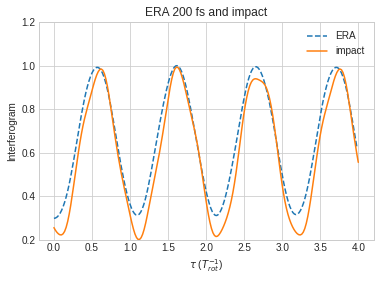

In [85]:
plt.xlabel('$\\tau$ ($T_{rot}^{-1}$)')
plt.ylabel('final ground state population')
plt.xlabel('$\\tau$ ($T_{rot}^{-1}$)')
plt.ylim(bottom=0.2, top=1.2)
plt.ylabel('Interferogram')
plt.title('ERA 200 fs and impact')
plt.plot(IntPu3.tau/Trot, IntPu3.inter, '--',label='ERA')
plt.plot(IntP.tau/Trot, IntP.inter, label='impact')
plt.legend(loc='upper right')
plt.show()

We see that the impact approximation is not satisfied for $\sigma = 200$ fs. Let's look at the intermediary value $\sigma = 150$ fs.

$FWHM = 150$ fs.

In [86]:
FWHM = 150. # (fs)
sigma = Ut.sigmaFromFWHM(FWHM)
time   = np.linspace(-7.*sigma, 4.5*Trot, 1000)
I0 = Ut.getI0(P, sigma, Da)
Pparam.update(I01 = I0, I02 = I0, sigma = sigma) 
Name   = 'ERA interferometer, 200 fs'
print("Trot/sigma:", Trot/Pparam['sigma'])
print('sigma:', sigma, '(au)')
print('Trot:',Trot,'(au)')


print("Tgrid window:", Twind, "Twind/Trot:", Twind/Trot, "Twind/sigma:", Twind/sigma, "Twind/tau_max:", Twind/tau[-1])
print("Time delay:", tau[-1]/Trot)
print("Time resolution:", (time[1] - time[0])/sigma)

print('P =',P, '(au)')
print('I0 =',I0, '(au)')
print('Checking pulse strength analytical: P =', Ut.getP(Da, I0 ,sigma), '(au)')
print('Checking pulse strength numerical: P =', Ut.getP_int(Da, I0 , 0., sigma), '(au)')

Trot/sigma: 13.185271632029568
sigma: 2633.4097007053874 (au)
Trot: 34722.22222222222 (au)
Tgrid window: 168539.24526995848 Twind/Trot: 4.853930263774805 Twind/sigma: 64.00038901079974 Twind/tau_max: 1.2195804682851268
Time delay: 3.98
Time resolution: 0.06640012246659989
P = 1.89 (au)
I0 = 0.0006847206138348087 (au)
Checking pulse strength analytical: P = 1.8899999999999995 (au)
Checking pulse strength numerical: P = 1.8900000000000001 (au)


In [87]:
IntPu4 = In.PulsesInterferometry(Pparam, time, Mparam, istate, mstate, dim, Name)
IntPu4.run_interferometry(options)

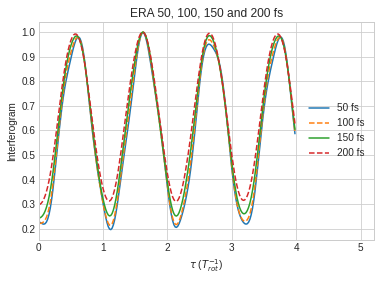

In [100]:
plt.xlabel('$\\tau$ ($T_{rot}^{-1}$)')
plt.ylabel('final ground state population')
plt.xlabel('$\\tau$ ($T_{rot}^{-1}$)')
plt.xlim(right=5.2)
plt.ylabel('Interferogram')
plt.title('ERA 50, 100, 150 and 200 fs')
plt.plot(IntPu2.tau/Trot, IntPu2.inter, label='50 fs')
plt.plot(IntPu.tau/Trot, IntPu.inter, '--',label='100 fs')
plt.plot(IntPu4.tau/Trot, IntPu4.inter, label='150 fs')
plt.plot(IntPu3.tau/Trot, IntPu3.inter, '--', label='200 fs')
plt.legend(loc='right')
plt.show()